# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, concat, expr, min, max, avg, desc, explode, split, udf, isnull
from pyspark.sql.types import IntegerType, BooleanType, ShortType, ArrayType, DoubleType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_event_data)

In [4]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
rows = df.count()
cols = len(df.columns)
print('rows = ', rows, 'columns = ', cols)

rows =  286500 columns =  18


In [6]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [4]:
df = df.dropna(subset=['sessionId', 'userId'])
df.count()

286500

In [5]:
df = df[df.userId!=""]
df.count()

278154

In [9]:
df_pd = df.toPandas()

In [10]:
df_pd.describe()

,itemInSession,length,registration,sessionId,status,ts
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [11]:
df_pd.nunique()

artist            17655
auth                  2
firstName           189
gender                2
itemInSession      1311
lastName            173
length            14865
level                 2
location            114
method                2
page                 19
registration        225
sessionId          2312
song              58480
status                3
ts               269770
userAgent            56
userId              225
dtype: int64

In [12]:
df_pd['auth'].unique()

array(['Logged In', 'Cancelled'], dtype=object)

In [13]:
df_pd['level'].unique()

array(['paid', 'free'], dtype=object)

In [14]:
df_pd['method'].unique()

array(['PUT', 'GET'], dtype=object)

In [15]:
df_pd['page'].unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation'], dtype=object)

In [16]:
df_pd['status'].unique()

array([200, 307, 404])

In [17]:
df_pd['userAgent'].unique()

array([ 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0',
       'Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20100101 Firefox/31.0',
       'Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
       '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebK

In [18]:
df_pd['location'].unique()

array(['Bakersfield, CA', 'Boston-Cambridge-Newton, MA-NH',
       'Tallahassee, FL', 'Spokane-Spokane Valley, WA',
       'Baltimore-Columbia-Towson, MD', 'Denver-Aurora-Lakewood, CO',
       'McAllen-Edinburg-Mission, TX', 'Columbus, GA-AL',
       'Phoenix-Mesa-Scottsdale, AZ',
       'Tampa-St. Petersburg-Clearwater, FL',
       'New York-Newark-Jersey City, NY-NJ-PA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD',
       'Atlanta-Sandy Springs-Roswell, GA',
       'Los Angeles-Long Beach-Anaheim, CA', 'Quincy, IL-MO',
       'New Philadelphia-Dover, OH', 'Kingsport-Bristol-Bristol, TN-VA',
       'Myrtle Beach-Conway-North Myrtle Beach, SC-NC', 'Boulder, CO',
       'Morgantown, WV', 'Minneapolis-St. Paul-Bloomington, MN-WI',
       'Oklahoma City, OK', 'Hartford-West Hartford-East Hartford, CT',
       'Lexington-Fayette, KY',
       'Virginia Beach-Norfolk-Newport News, VA-NC',
       'Louisville/Jefferson County, KY-IN',
       'Houston-The Woodlands-Sugar Land, TX', 'Vi

In [19]:
df_pd['song'].unique()

array(['Rockpools', 'Canada', 'Time For Miracles', ..., 'Black Woman',
       'King Of The Stereo', 'Tops'], dtype=object)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
df.select("page").distinct().show()  

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [21]:
df_churn_user = df[df.page=="Cancellation Confirmation"].select("userId").distinct()
df_churn_user.count()

52

In [22]:
list_churn_user = df_churn_user.rdd.flatMap(lambda x: x).collect()
list_churn_user

['125',
 '51',
 '54',
 '100014',
 '101',
 '29',
 '100021',
 '87',
 '73',
 '3',
 '28',
 '100022',
 '100025',
 '300007',
 '100006',
 '18',
 '70',
 '100005',
 '17',
 '100007',
 '300001',
 '100009',
 '100015',
 '200024',
 '100003',
 '103',
 '100024',
 '53',
 '122',
 '200017',
 '58',
 '100011',
 '100019',
 '100012',
 '200018',
 '200016',
 '200020',
 '106',
 '143',
 '32',
 '200001',
 '105',
 '200011',
 '100023',
 '100013',
 '100017',
 '121',
 '12',
 '200015',
 '129',
 '200021',
 '100001']

In [23]:
df_churn = df.withColumn("churn", df.userId.isin(list_churn_user))

In [24]:
df_churn.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|false|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

Data exploration for different groups of users

In [25]:
# number of users depending on gender and churn
df_churn.dropDuplicates(['userId']).groupby(['gender','churn']).count().show() 

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M| true|   32|
|     F|false|   84|
|     F| true|   20|
|     M|false|   89|
+------+-----+-----+



In [26]:
df_churn.dropDuplicates(['userId']).groupby(['method','churn']).count().show() 

+------+-----+-----+
|method|churn|count|
+------+-----+-----+
|   GET| true|   27|
|   PUT|false|   85|
|   PUT| true|   25|
|   GET|false|   88|
+------+-----+-----+



In [27]:
# extract the state from location
df_churn = df_churn.withColumn("state", expr("substring(location, length(location)-1, length(location))"))

In [28]:
df_states = df_churn.dropDuplicates(['userId']).groupby(['state','churn']).count().toPandas()
df_states.describe()

,count
count,62.000000
mean,3.629032
std,4.185196
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,27.000000


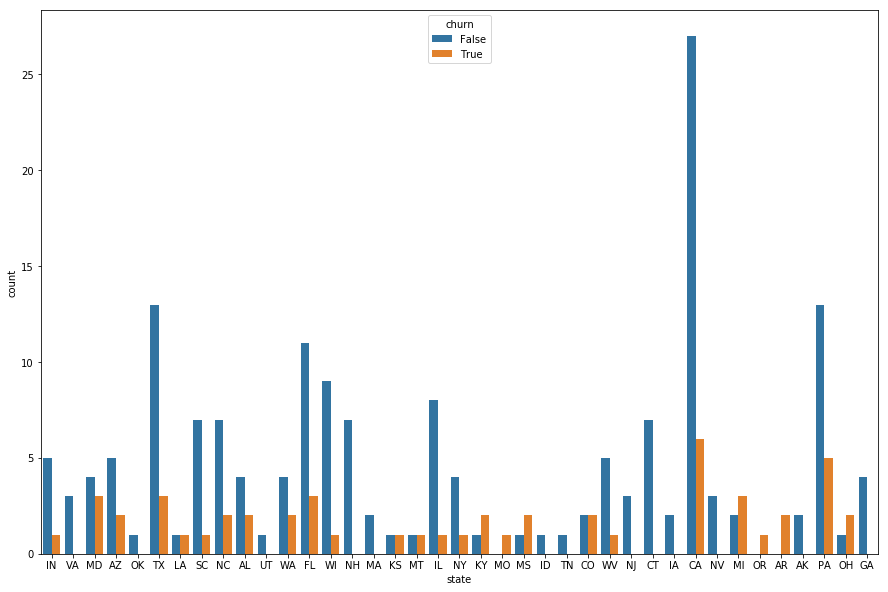

In [29]:
# distribution of users collected by state and churn
df_states = df_churn.dropDuplicates(['userId']).groupby(['state','churn']).count().toPandas()
# df_states.plot.bar("state")
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='state', y='count', hue='churn', data=df_states, ax=ax)
plt.show()

In [30]:
# most popular songs
df_num_songs = df_churn.dropDuplicates(['userId']).groupby(['song','churn']).count().sort('count', ascending=False).show()

+--------------------+-----+-----+
|                song|churn|count|
+--------------------+-----+-----+
|                null|false|   88|
|                null| true|   27|
|       Sehr kosmisch|false|    2|
|      You're The One|false|    2|
|Taking Control (A...|false|    1|
|Phoenix (Basement...|false|    1|
|He's The DJ_ I'm ...|false|    1|
|          Hammerhart|false|    1|
|         The Shining|false|    1|
|Still Smokin (D L...|false|    1|
|      Little Darlin'|false|    1|
|                FACK|false|    1|
|   Distance And Time| true|    1|
|        Jernskjorten|false|    1|
|          Yesterdays|false|    1|
|         What I Mean| true|    1|
|Judgement Begins ...|false|    1|
|Citizens Of Tomorrow|false|    1|
|          Dreamlover| true|    1|
|     I Need A Dollar|false|    1|
+--------------------+-----+-----+
only showing top 20 rows



In [31]:
# Show the page use distribution between churn and no churn users
df_page_churn = df_churn.filter(df_churn.churn==1).groupby(["page"]).count()
df_page_churn = df_page_churn.withColumnRenamed('count', 'count_churn')
df_page_nochurn = df_churn.filter(df_churn.churn==0).groupby(["page"]).count()
df_page_nochurn = df_page_nochurn.withColumnRenamed('count', 'count_no_churn')
df_page = df_page_churn.join(df_page_nochurn, on=['page'], how='outer')
df_page.show()

+--------------------+-----------+--------------+
|                page|count_churn|count_no_churn|
+--------------------+-----------+--------------+
|              Cancel|         52|          null|
|    Submit Downgrade|          9|            54|
|         Thumbs Down|        496|          2050|
|                Home|       1672|          8410|
|           Downgrade|        337|          1718|
|         Roll Advert|        967|          2966|
|              Logout|        553|          2673|
|       Save Settings|         58|           252|
|Cancellation Conf...|         52|          null|
|               About|         56|           439|
|            Settings|        270|          1244|
|     Add to Playlist|       1038|          5488|
|          Add Friend|        636|          3641|
|            NextSong|      36394|        191714|
|           Thumbs Up|       1859|         10692|
|                Help|        239|          1215|
|             Upgrade|        112|           387|


In [32]:
# Show the page use distribution between 'paid' and 'free' churn users
df_churn_paid = df_churn.filter(df_churn.churn==0).filter(df_churn.level=="paid").groupby(["page"]).count()
df_churn_paid = df_churn_paid.withColumnRenamed('count', 'count_paid')
df_churn_free = df_churn.filter(df_churn.churn==0).filter(df_churn.level=="free").groupby(["page"]).count()
df_churn_free = df_churn_free.withColumnRenamed('count', 'count_free')
df_page_1 = df_churn_paid.join(df_churn_free, on=['page'], how='outer')
df_page_1.show()

+----------------+----------+----------+
|            page|count_paid|count_free|
+----------------+----------+----------+
|Submit Downgrade|        54|      null|
|     Thumbs Down|      1624|       426|
|            Home|      6361|      2049|
|       Downgrade|      1718|      null|
|     Roll Advert|       187|      2779|
|          Logout|      1955|       718|
|   Save Settings|       187|        65|
|           About|       367|        72|
|        Settings|       973|       271|
| Add to Playlist|      4587|       901|
|      Add Friend|      2934|       707|
|        NextSong|    158907|     32807|
|       Thumbs Up|      8960|      1732|
|            Help|       964|       251|
|         Upgrade|      null|       387|
|           Error|       179|        41|
|  Submit Upgrade|      null|       127|
+----------------+----------+----------+



In [33]:
df_churn.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|state|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|false|   CA|
|    Five Iron Frenzy|Logged In|    Micah|  

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Features for ML modelling:
1. User churn or no churn (1 - churn, 0 - no churn)
2. Time period after registration (days)
3. The number of played songs by user
4. User paid or free (1 - paid, 0 - free)
5. User's gender (1 - female, 0 - male)
6. User downgrade (count)
7. Time period between downgrade and churn
8. User's location (one hot encoding of states)


In [34]:
# Feature 1 - User churn or no churn (1 - churn, 0 - no churn)
user_is_churn = df_churn.select("userId", "churn").dropDuplicates()
user_is_churn = user_is_churn.select("userId", user_is_churn.churn.cast(IntegerType())).sort('userId')

In [35]:
feature_set = user_is_churn

In [36]:
# Feature 2 - Time period after registration (days)
user_max_timestamp = df_churn.groupby('userId').max('ts').sort('userId')
user_max_timestamp = user_max_timestamp.withColumnRenamed('max(ts)', 'last_date_by_userId')
user_registration_timestamp = df_churn.select('userId', 'registration').dropDuplicates().sort('userId')
user_reg_days = user_registration_timestamp.join(user_max_timestamp, on=['userId'], how='inner')
user_reg_days = user_reg_days \
    .withColumn('days_after_reg', (user_reg_days['last_date_by_userId']-user_reg_days['registration'])/(1000*60*60*24)) \
    .withColumn('days_after_reg', col('days_after_reg').cast(IntegerType())) \
    .drop('last_date_by_userId') \
    .drop('registration') \
    .sort('userId')

In [37]:
# add to feature set
feature_set = feature_set.join(user_reg_days, on=['userId'], how='left').sort('userId')

In [38]:
# Feature 3 - The number of played songs by user
user_num_songs = df_churn.filter(df_churn.page=='NextSong').dropDuplicates().groupby('userId').count()
user_num_songs = user_num_songs.withColumnRenamed('count', 'num_songs').sort('userId')

In [39]:
# add to feature set
feature_set = feature_set.join(user_num_songs, on=['userId'], how='left').sort('userId')

In [40]:
# Feature 4 - User paid or free (1 - paid, 0 - free)
user_paid = df_churn.groupby('userId', 'level').agg(max(df_churn.ts).alias('last_date_by_userId')).sort('userId')
user_recent_paid_status_time = user_paid.groupby('userId').agg(max('last_date_by_userId').alias('last_date_by_userId'))
user_recent_paid_status = user_recent_paid_status_time.join(user_paid, on=['userId', 'last_date_by_userId']).select(user_paid.userId, 'level').sort('userId')
user_recent_paid_status = user_recent_paid_status.replace(['free', 'paid'], ['0', '1'], 'level')
user_recent_paid_status = user_recent_paid_status.select('userId', col('level').cast(IntegerType()))

In [41]:
# add to feature set
feature_set = feature_set.join(user_recent_paid_status, on=['userId'], how='left').sort('userId')

In [42]:
# Feature 5 - User's gender (1 - female, 0 - male)
user_gender = df_churn.select('userId', 'gender').distinct()
user_gender = user_gender.replace(['M', 'F'], ['0', '1'], 'gender')
user_gender = user_gender.select("userId", user_gender.gender.cast(IntegerType()))

In [43]:
# add to feature set
feature_set = feature_set.join(user_gender, on=['userId'], how='left').sort('userId')

In [44]:
# Feature 6 - User downgrade count
user_downgrade = df_churn.filter(df_churn.page=='Downgrade').dropDuplicates().groupby('userId').count()
user_downgrade = user_downgrade.withColumnRenamed('count', 'downgrade').sort('userId')

In [45]:
# add to feature set
feature_set = feature_set.join(user_downgrade, on=['userId'], how='left').sort('userId')

In [46]:
# Feature 7 - User submit downgrade count
user_submit_downgrade = df_churn.filter(df_churn.page=='Submit Downgrade').dropDuplicates().groupby('userId').count()
user_submit_downgrade = user_submit_downgrade.withColumnRenamed('count', 'submit_downgrade').sort('userId')

In [47]:
# add to feature set
feature_set = feature_set.join(user_submit_downgrade, on=['userId'], how='left').sort('userId')

In [48]:
# Feature 8 - Time between downgrade and churn
downgrade_to_churn = df_churn.filter((df_churn.churn==1) & (df_churn.page=='Downgrade')).dropDuplicates().groupby('userId').agg(max('ts')-min('ts'))
downgrade_to_churn = downgrade_to_churn.withColumnRenamed('(max(ts) - min(ts))', 'time_dow_to_churn').sort('userId')

In [49]:
# add to feature set
feature_set = feature_set.join(downgrade_to_churn, on=['userId'], how='left').sort('userId')

In [50]:
# Feature 9 - User's location (one hot encoding of states)
user_state = df_churn.select('userId', 'state').distinct().sort('userID')
# convert names of states into numbers
indexer = StringIndexer(inputCol='state', outputCol='state_numeric')
user_state_indexed = indexer.fit(user_state).transform(user_state)
# make a list of states names
states = user_state_indexed.select(['state', 'state_numeric']).distinct().sort('state_numeric')
list_states = states.select('state').rdd.flatMap(lambda x: x).collect()
# one hot encoding the numbers of states
encoder = OneHotEncoder(inputCol='state_numeric', outputCol='state_onehot')
user_state_onehot = encoder.transform(user_state_indexed)
#convert one hot encoded vector into multiple columns and rename of columns
vector_udf = udf(lambda vector: vector.toArray().tolist(), ArrayType(DoubleType()))
user_state_onehot = user_state_onehot.withColumn('state_onehot_vec', vector_udf('state_onehot'))

arr_size = len(list_states)
user_state_onehot_new = user_state_onehot.select(['state_onehot_vec']+[expr('state_onehot_vec[' + str(x) + ']') for x in range(0, arr_size)])

for x in range(0, arr_size):
    user_state_onehot_new = user_state_onehot_new.withColumnRenamed('state_onehot_vec['+ str(x) + ']', list_states[x])

user_state_onehot_new = user_state_onehot_new.distinct()
user_state_encoded = user_state_onehot.join(user_state_onehot_new, on=['state_onehot_vec'], how='inner') 

# drop unnecessary columns
user_state_encoded = user_state_encoded.drop('state') \
    .drop('state_onehot_vec') \
    .drop('state_numeric') \
    .drop('state_onehot')

In [51]:
# add to feature set
feature_set = feature_set.join(user_state_encoded, on=['userId'], how='left').sort('userId')

In [52]:
feature_set = feature_set.fillna(0)
feature_set.show(5)

+------+-----+--------------+---------+-----+------+---------+----------------+-----------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|userId|churn|days_after_reg|num_songs|level|gender|downgrade|submit_downgrade|time_dow_to_churn| CA| PA| TX| FL| WI| IL| NC| SC| AZ| MD| CT| NH| IN| WA| AL| WV| MI| NY| CO| GA| KY| NJ| NV| OH| VA| MS| MA| IA| AK| KS| AR| MT| LA| ID| OR| TN| MO| OK| UT|
+------+-----+--------------+---------+-----+------+---------+----------------+-----------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|    10|    0|            51|      673|    1|     0|        7|               0|                0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|1.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [53]:
# number of columns in feature dataset
len(feature_set.columns)

48

In [54]:
feature_set.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [55]:
X = feature_set.select([col for col in feature_set.columns[2:]])

In [56]:
y = feature_set.select('churn')

 ML Pipeline

In [65]:
# build a pipeline for the ML modelling
random_state = 42
train, test = feature_set.randomSplit([0.8, 0.2])

assembler = VectorAssembler(inputCols=feature_set.columns[2:],outputCol='featuresassemble')
scaler = StandardScaler(inputCol="featuresassemble", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

The Logistic Regression Classifier model

In [56]:
log_reg = LogisticRegression()

pipeline_log_reg = Pipeline(stages=[assembler, scaler, indexer, log_reg])

param_grid_log_reg = ParamGridBuilder() \
    .addGrid(log_reg.regParam,[0.01]) \
    .addGrid(log_reg.elasticNetParam,[0.0]) \
    .addGrid(log_reg.aggregationDepth,[2]) \
    .build()

cv_log_reg = CrossValidator(estimator=pipeline_log_reg,
                          estimatorParamMaps=param_grid_log_reg,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [57]:
model_cv_log_reg = cv_log_reg.fit(train)

In [58]:
res_log_reg = model_cv_log_reg.transform(test)

In [59]:
model_cv_log_reg.avgMetrics

[0.8400583872281986]

In [60]:
res = model_cv_log_reg.transform(train).select('label', 'prediction')
TruePos = res.filter((res.prediction==1) & (res.label == res.prediction)).count()
TrueNeg = res.filter((res.prediction==0) & (res.label == res.prediction)).count()
FalsPos = res.filter((res.prediction==1) & (res.label != res.prediction)).count()
FalsNeg = res.filter((res.prediction==0) & (res.label != res.prediction)).count()
accuracy = res.filter(res.label == res.prediction).count()/res.count()
precision = TruePos / (TruePos + FalsPos)
recall = TruePos / (TruePos + FalsNeg)
f1score = 2 * precision * recall / (precision + recall)

In [61]:
print('Results for Logistic Regression Classifier (train):')
print('Accuracy = ', accuracy)
print('Precision = ', precision)
print('Recall = ', recall)
print('f1 score = ', f1score)

Results for Logistic Regression Classifier (train):
Accuracy =  0.9247311827956989
Precision =  0.9375
Recall =  0.7142857142857143
f1 score =  0.8108108108108109


In [62]:
res = model_cv_log_reg.transform(test).select('label', 'prediction')
TruePos = res.filter((res.prediction==1) & (res.label == res.prediction)).count()
TrueNeg = res.filter((res.prediction==0) & (res.label == res.prediction)).count()
FalsPos = res.filter((res.prediction==1) & (res.label != res.prediction)).count()
FalsNeg = res.filter((res.prediction==0) & (res.label != res.prediction)).count()
accuracy = res.filter(res.label == res.prediction).count()/res.count()
precision = TruePos / (TruePos + FalsPos)
recall = TruePos / (TruePos + FalsNeg)
f1score = 2 * precision * recall / (precision + recall)

In [63]:
print('Results for Logistic Regression Classifier (test):')
print('Accuracy = ', accuracy)
print('Precision = ', precision)
print('Recall = ', recall)
print('f1 score = ', f1score)

Results for Logistic Regression Classifier (test):
Accuracy =  0.8205128205128205
Precision =  0.8
Recall =  0.4
f1 score =  0.5333333333333333


Compare results on train and test datasets, we can see that f1-score for training set is 0.81, but f1-score for test set is 0.53. That looks like overfitting of the model.

 The Decision Tree Classifier model

In [66]:
dec_tree = DecisionTreeClassifier()

pipeline_dec_tree = Pipeline(stages=[assembler, scaler, indexer, dec_tree])

param_grid_dec_tree = ParamGridBuilder() \
    .addGrid(dec_tree.maxDepth,[3, 5]) \
    .addGrid(dec_tree.impurity,['entropy', 'gini']) \
    .build()

cv_dec_tree = CrossValidator(estimator=pipeline_dec_tree,
                          estimatorParamMaps=param_grid_dec_tree,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [67]:
model_cv_dec_tree = cv_dec_tree.fit(train)

In [68]:
res_dec_tree = model_cv_dec_tree.transform(test)

In [69]:
model_cv_dec_tree.avgMetrics

[0.8392903392903392,
 0.8181664014997347,
 0.9116742311186756,
 0.8042091653202763]

In [70]:
res = model_cv_dec_tree.transform(train).select('label', 'prediction')
TruePos = res.filter((res.prediction==1) & (res.label == res.prediction)).count()
TrueNeg = res.filter((res.prediction==0) & (res.label == res.prediction)).count()
FalsPos = res.filter((res.prediction==1) & (res.label != res.prediction)).count()
FalsNeg = res.filter((res.prediction==0) & (res.label != res.prediction)).count()
accuracy = res.filter(res.label == res.prediction).count()/res.count()
precision = TruePos / (TruePos + FalsPos)
recall = TruePos / (TruePos + FalsNeg)
f1score = 2 * precision * recall / (precision + recall)

In [71]:
print('Results for Decision Tree Classifier (train):')
print('Accuracy = ', accuracy)
print('Precision = ', precision)
print('Recall = ', recall)
print('f1 score = ', f1score)

Results for Decision Tree Classifier (train):
Accuracy =  0.9456521739130435
Precision =  1.0
Recall =  0.75
f1 score =  0.8571428571428571


In [72]:
res = model_cv_dec_tree.transform(test).select('label', 'prediction')
TruePos = res.filter((res.prediction==1) & (res.label == res.prediction)).count()
TrueNeg = res.filter((res.prediction==0) & (res.label == res.prediction)).count()
FalsPos = res.filter((res.prediction==1) & (res.label != res.prediction)).count()
FalsNeg = res.filter((res.prediction==0) & (res.label != res.prediction)).count()
accuracy = res.filter(res.label == res.prediction).count()/res.count()
precision = TruePos / (TruePos + FalsPos)
recall = TruePos / (TruePos + FalsNeg)
f1score = 2 * precision * recall / (precision + recall)

In [73]:
print('Results for Decision Tree Classifier (test):')
print('Accuracy = ', accuracy)
print('Precision = ', precision)
print('Recall = ', recall)
print('f1 score = ', f1score)

Results for Decision Tree Classifier (test):
Accuracy =  0.9024390243902439
Precision =  1.0
Recall =  0.6666666666666666
f1 score =  0.8


The result for Decision Tree Model is very good. f1-score is 0.85 for training set and 0.8 for test set, very good model.

In [94]:
best_model = model_cv_dec_tree

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.